## Import the libraries and download the data

In [ ]:
import os
import pandas as pd
from google.colab import drive
from datetime import datetime
import plotly.express as px
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn import metrics
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

In [ ]:
drive.mount('/content/drive/', force_remount = True)
path = '/content/drive/My Drive/Colab Notebooks/02 - AML 2404 - AI and ML Lab/BT_SENT.csv'
df = pd.read_csv(path, header = 0 , parse_dates=['Date'])

df.head(3)

Mounted at /content/drive/


,Unnamed: 0,Date,Price,Sentiments
0,545,2020-01-01,7199.8,0.2
1,544,2020-01-02,6967.0,0.4
2,543,2020-01-03,7343.1,0.4


## Time series analysis model

### Drop the 'original' index colum

In [ ]:
df = df.loc[:, ['Date', 'Price', 'Sentiments']]
df.head(3)

,Date,Price,Sentiments
0,2020-01-01,7199.8,0.2
1,2020-01-02,6967.0,0.4
2,2020-01-03,7343.1,0.4


### Adjust date format

In [ ]:
df['Date'][0]

Timestamp('2020-01-01 00:00:00')

In [ ]:
df['Date'][0].strftime('%d %b %y')

'01 Jan 20'

In [ ]:
df['Date'] = df.loc[:, 'Date'].apply(lambda dt: dt.strftime('%d %b %y'))
df.head(3)

,Date,Price,Sentiments
0,01 Jan 20,7199.8,0.2
1,02 Jan 20,6967.0,0.4
2,03 Jan 20,7343.1,0.4


In [ ]:
fig = px.bar(df, 
             x='Date', 
             y="Price",
             title='Bitcoin\'s Prices',
             width=1_400
             )

fig.update_yaxes(title='Price in US Dolars')
fig.update_xaxes(tickangle=60)
fig.show()

### Scaling

In [ ]:
scalers = [
           ('Price - Robust Scaler', RobustScaler()), 
           ('Price - Standard Scaler', StandardScaler()), 
           ('Price - MinMax Scaler', MinMaxScaler()), 
           ('Price - MaxAbs Scaler', MaxAbsScaler())
           ]

for column, scaler in scalers:
    df[column] = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

df.head(3)

,Date,Price,Sentiments,Price - Robust Scaler,Price - Standard Scaler,Price - MinMax Scaler,Price - MaxAbs Scaler
0,01 Jan 20,7199.8,0.2,-0.166641,-0.870145,0.040429,0.113310
1,02 Jan 20,6967.0,0.4,-0.175372,-0.883310,0.036464,0.109646
2,03 Jan 20,7343.1,0.4,-0.161266,-0.862041,0.042870,0.115565


### Testing the Scalers

In [ ]:
def to_sequences(data, sequence_length):
    return np.array([data[index: index + sequence_length] for 
                     index in range(len(data) - sequence_length)])

In [ ]:
def preprocess(data_raw, sequence_length, train_split):
    data = to_sequences(data_raw, sequence_length)
    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

In [ ]:
def get_model(dropout, window_size, input_data):

    model = keras.Sequential()
    
    model.add(Bidirectional(
        CuDNNLSTM(window_size, return_sequences=True),
        input_shape=(window_size, input_data.shape[-1])
        ))

    model.add(Dropout(rate=dropout))

    model.add(Bidirectional(
        CuDNNLSTM((window_size * 2), return_sequences=True)
        ))

    model.add(Dropout(rate=dropout))

    model.add(Bidirectional(
        CuDNNLSTM(window_size, return_sequences=False)
        ))

    model.add(Dense(units=1))

    model.add(Activation('linear'))

    return model

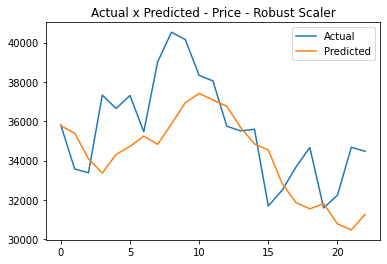

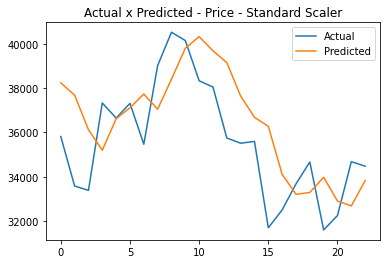

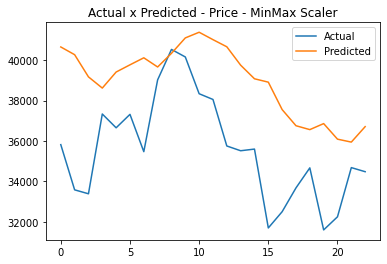

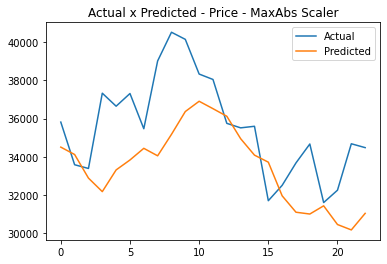

In [ ]:
sequence_length = 100
split = 0.95

for scaler, scaler_function in scalers:
    scaled_price = np.array(
        [[price] for price in df[scaler]]
        )

    X_train, y_train, X_test, y_test = preprocess(scaled_price,
                                                  sequence_length, 
                                                  train_split=split)
    
    model = get_model(dropout=0.25, 
                      window_size=(sequence_length - 1), 
                      input_data=X_train)

    model.compile(
        loss='mae',
        optimizer='adam',
        metrics='accuracy'
        )
    
    hist = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=20,
        shuffle=False,
        # validation_split=0.1,
        verbose=0,
        )
    
    y_predicted = model.predict(X_test)
    y_test = scaler_function.inverse_transform(y_test)
    y_predicted = scaler_function.inverse_transform(y_predicted)
    
    # Accuracy across the epochs
    plt.plot(y_test, label='Actual')
    plt.plot(y_predicted, label='Predicted')
    plt.title(f'Actual x Predicted - {scaler}')
    plt.legend()
    plt.show()

The best results were obtained with the StandardScaler

### Testing the Optimizers

In [ ]:
scalers[1]

('Price - Standard Scaler',
 StandardScaler(copy=True, with_mean=True, with_std=True))

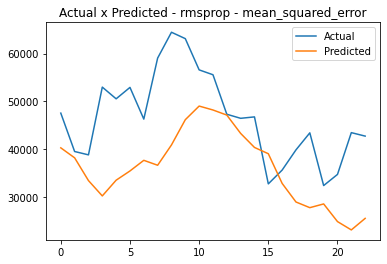

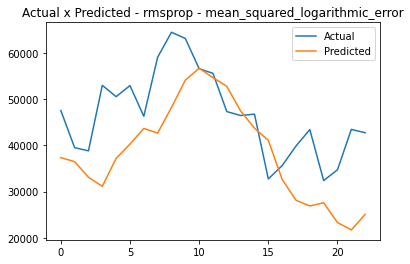

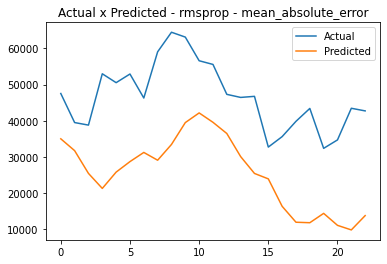

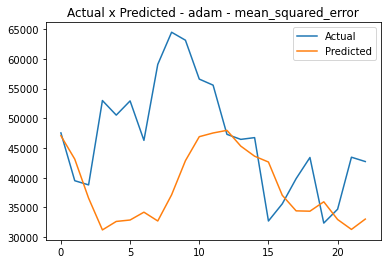

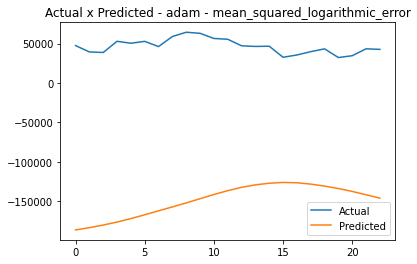

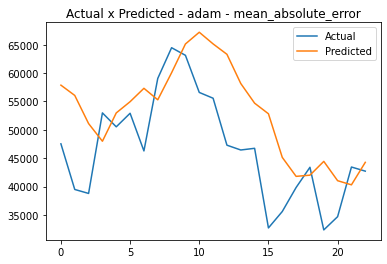

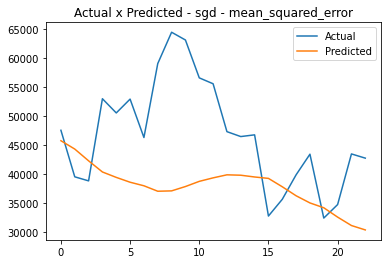

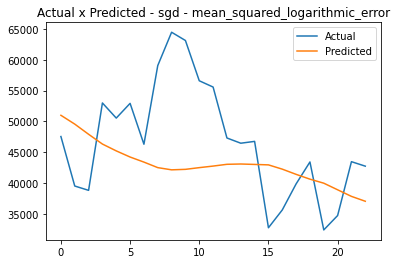

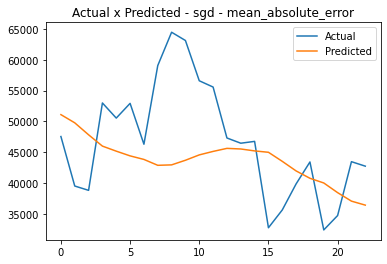

In [ ]:
scaled_price = np.array(
        [[price] for price in df[scalers[1][0]]]
        )


for optimizer_method in ['rmsprop', 'adam', 'sgd']:
    for loss_function in ['mean_squared_error', 
                          'mean_squared_logarithmic_error', 
                          'mean_absolute_error']:
    
        X_train, y_train, X_test, y_test = preprocess(scaled_price,
                                                      sequence_length, 
                                                      train_split=split)
        
        model = get_model(dropout=0.25, 
                          window_size=(sequence_length - 1), 
                          input_data=X_train)
        
        model.compile(
            loss=loss_function,
            optimizer=optimizer_method,
            metrics='accuracy'
            )
        
        hist = model.fit(
            X_train,
            y_train,
            epochs=50,
            batch_size=20,
            shuffle=False,
            verbose=0,
            )
        
        y_predicted = model.predict(X_test)
        y_test = scaler_function.inverse_transform(y_test)
        y_predicted = scaler_function.inverse_transform(y_predicted)
        
        # Accuracy across the epochs
        plt.plot(y_test, label='Actual')
        plt.plot(y_predicted, label='Predicted')
        plt.title(f'Actual x Predicted - {optimizer_method} - {loss_function}')
        plt.legend()
        plt.show()

The best model is the one with the Adam method as optimizer and mean_absolute_error as loss function

### Best model

In [ ]:
scaled_price = np.array(
        [[price] for price in df[scalers[1][0]]]
        )


optimizer_method = 'adam'
loss_function = 'mean_absolute_error'
    
X_train, y_train, X_test, y_test = preprocess(scaled_price,
                                                sequence_length, 
                                                train_split=split)

model = get_model(dropout=0.25, 
                    window_size=(sequence_length - 1), 
                    input_data=X_train)
        
model.compile(
    loss=loss_function,
    optimizer=optimizer_method,
    metrics=['mae', 'accuracy']
    )
        
hist = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=20,
    shuffle=False,
    verbose=0,
    )
        
y_predicted = model.predict(X_test)
y_test = scaler_function.inverse_transform(y_test)
y_predicted = scaler_function.inverse_transform(y_predicted)

In [ ]:
dict_test = {'Days': list(range(y_test.shape[0])),
             'Price': y_test.tolist(),
             'Actual/Predicted': ['Actual']*y_test.shape[0]}

dict_predicted = {'Days': list(range(y_test.shape[0])),
                  'Price': y_predicted.tolist(),
                  'Actual/Predicted': ['Predicted']*y_test.shape[0]}

aux = pd.DataFrame(dict_test)
aux2 = pd.DataFrame(dict_predicted)

aux = aux.append(aux2)

aux['Price'] = aux.loc[:, 'Price'].apply(lambda x: x[0])

In [ ]:
fig = px.line(data_frame=aux,
              x='Days', 
              y='Price',
              color='Actual/Predicted',
              title='Bitcoin\'s Prices',
              width=1_000,
              labels={'Actual/Predicted': 'Price'})

fig.update_traces(mode='lines+markers')
fig.update_xaxes(title='Days')
fig.update_yaxes(title='Price in US Dolars')
fig.show()

In [ ]:
model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_201 (Bidirecti (None, 99, 198)           80784     
_________________________________________________________________
dropout_134 (Dropout)        (None, 99, 198)           0         
_________________________________________________________________
bidirectional_202 (Bidirecti (None, 99, 396)           630432    
_________________________________________________________________
dropout_135 (Dropout)        (None, 99, 396)           0         
_________________________________________________________________
bidirectional_203 (Bidirecti (None, 198)               393624    
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 199       
_________________________________________________________________
activation_67 (Activation)   (None, 1)               